In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
import numpy as np
import nest
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rcParams 
import unicodeit
import ipywidgets as widgets
from ipywidgets import interact
import inspect
from joblib import Memory
from consts import Paths
from pathlib import Path
from os import makedirs
from dataclasses import dataclass


CACHE_DIR = Path(Paths.DATA_DIR) / 'myoga_cache'
makedirs(CACHE_DIR, exist_ok=True)

nest.set_verbosity('M_ERROR') 
figures = {}
memory = Memory(location=CACHE_DIR, verbose=0)
plt.ion()
plt.rcParams["axes.grid"] = True



              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.8.0
 Built: Aug 27 2024 04:33:06

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [3]:
# utility functions
def time_max_voltage(x):
    return x["times"][np.argmax(x["V_m"])] * 100


def plot_axes_legend(ax):
    ax.set_xlabel("Time (ms)")
    ax.legend()
    ax.set_ylabel("V_m")


def plot_voltage(ax, data, color=None, label="", linewidth=1, plot_max=True):
    if plot_max:
        ax.axvline(time_max_voltage(data), color=color, linewidth=0.5)
    ax.plot(data["V_m"], color=color, linewidth=linewidth, label=label)


def plot_threshold(ax, level=-55):
    ax.axhline(-55, color="k", linestyle="--")


def single_figure_setup(draw_fun, **kwargs):
    # might be the best function that's in here
    # store figures in dict to close them before re-creating plot (avoid keeping many figs in memory)
    # FYI figure number will keep increasing when you run different cells, but the total number of figs opened
    # will stay the same. you can check with plt.get_fignums()
    name = draw_fun.__name__
    if name in figures:
        plt.close(figures.pop(name)[0])

    with plt.ioff():
        fig, ax = plt.subplots(1, 1)
        figures[name] = [fig, ax]
    # first show widgets
    display(
        widgets.interactive(
            draw_fun,
            **kwargs,
            fig=widgets.fixed(fig),
            ax=widgets.fixed(ax),
        )
    )
    # then the figure. this is the only display that will be called for this figure
    display(fig.canvas)


def heatmap(
    data, row_labels, col_labels, ax=None, cbar_kw=None, cbarlabel="", **kwargs
):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current Axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    len(data)
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right", rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1] + 1) - 0.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0] + 1) - 0.5, minor=True)
    ax.grid(which="minor", color="w", linestyle="-", linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(
    im,
    data=None,
    valfmt="{x:.2f}",
    textcolors=("black", "white"),
    threshold=None,
    **textkw,
):
    """
    A function to
      a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max()) / 2.0

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center", verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            text.set_picker(True)
            texts.append(text)

    return texts

# MSO model
we'll just use the complete four input model as a basis, and create simpler model from here. since it's easy enough i think this is for the best

In [4]:
@dataclass
class ParamsMSO4:
    delay_exc_i: float = 5
    delay_exc_c: float = 5
    # delay_exc_i - delay_exc_c = ITD
    delay_inh_i: float = 5
    delay_inh_c: float = 5
    tone: int = 100
    tau_rise_exc: float = 0.2
    tau_rise_in: float = 0.2
    tau_decay_ex: float = 0.5
    tau_decay_in: float = 1.5
    weight_exc_i: float = 2
    weight_exc_c: float = 2
    weight_inh_i: float = -4
    weight_inh_c: float = -4
    I_ext: int = 0
    time_sim: int = 15
    v_th: int = -40
    c_mso: int = 1


@memory.cache
def mso(p: ParamsMSO4):
    nest.ResetKernel()
    nest.set(local_num_threads=16, resolution=0.01, rng_seed=42)

    input = nest.Create(
        "spike_generator",
        params={
            "spike_times": np.around(np.arange(1, p.time_sim + 1, 1000 / p.tone), 2)
        },
    )
    mso = nest.Create(
        "iaf_cond_beta",
        params={
            "V_th": p.v_th,
            "C_m": p.c_mso,
            "tau_rise_ex": p.tau_rise_exc,
            "tau_rise_in": p.tau_rise_in,
            "tau_decay_ex": p.tau_decay_ex,
            "tau_decay_in": p.tau_decay_in,
            "I_e": p.I_ext,
        },
    )
    rec = nest.Create("multimeter", 1, {"record_from": ["V_m"], "interval": 0.01})

    nest.Connect(rec, mso, "all_to_all")
    nest.Connect(
        input,
        mso,
        "one_to_one",
        syn_spec={"weight": p.weight_exc_i, "delay": p.delay_exc_i},
    )
    nest.Connect(
        input,
        mso,
        "one_to_one",
        syn_spec={"weight": p.weight_exc_c, "delay": p.delay_exc_c},
    )
    nest.Connect(
        input,
        mso,
        "one_to_one",
        syn_spec={"weight": p.weight_inh_i, "delay": p.delay_inh_i},
    )
    nest.Connect(
        input,
        mso,
        "one_to_one",
        syn_spec={"weight": p.weight_inh_c, "delay": p.delay_inh_c},
    )
    nest.Simulate(p.time_sim)
    return rec.get("events")


def angle_to_itd(angle, w_head: int = 22, v_sound: int = 33000):
    delta_x = w_head * np.sin(np.deg2rad(angle))
    return round(1000 * delta_x / v_sound, 2)

In [5]:
def paramsMSO2(
    delta_t: float = 0.4, weight_inh: float = -4, weight_exc: float = 4, **kwargs
) -> ParamsMSO4:
    params = ParamsMSO4(weight_inh_i=weight_inh, weight_exc_i=weight_exc, **kwargs)
    params.delay_inh_i = params.delay_exc_i + delta_t
    params.weight_exc_c = 0
    params.weight_inh_c = 0
    return params

# single PSP sum
this shows we can move peak voltage times. i included a slider for the inhibitory weight to show that changing the synaptic weight impacts the size of the shift considerably. what does this mean?

interactive(children=(FloatSlider(value=-0.4, description='delta_t', max=1.0, min=-1.5), IntSlider(value=-4, d…

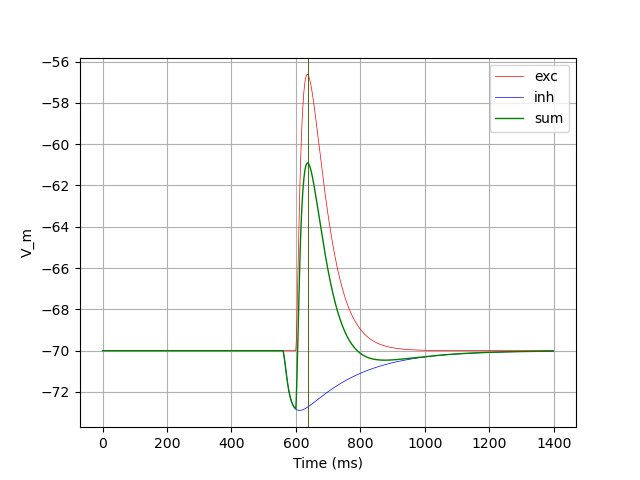

In [6]:
def show_mso_two_inputs(delta_t, weight_inh, fig, ax):
    [l.remove() for l in ax.lines]

    only_ex = mso(paramsMSO2(delta_t=delta_t, weight_inh=0))
    only_inh = mso(paramsMSO2(delta_t=delta_t, weight_inh=weight_inh, weight_exc=0))
    res_sum = mso(paramsMSO2(delta_t=delta_t, weight_inh=weight_inh))
    plot_voltage(ax, only_ex, color="r", linewidth=0.5, label="exc")
    plot_voltage(ax, only_inh, color="b", linewidth=0.5, label="inh", plot_max=False)
    plot_voltage(ax, res_sum, color="g", linewidth=1, label="sum")
    plot_axes_legend(ax)
    print(
        unicodeit.replace(
            f"peak distance (t_{{no-inh}}-t_{{inh}}) = {time_max_voltage(only_ex) - time_max_voltage(res_sum)}"
        )
    )
    p = paramsMSO2(delta_t=delta_t)
    print(f"ipsi exc -> {p.delay_exc_i}ms,\n     inh -> {p.delay_inh_i}ms")


single_figure_setup(
    show_mso_two_inputs,
    delta_t=widgets.FloatSlider(min=-1.5, max=1, step=0.1, value=-0.4),
    weight_inh=widgets.IntSlider(min=-20, max=0, step=1, value=-4),
)

# Three inputs

In [7]:
def paramsMSO3(
    angle: float = 0,
    deltat_inh: float = 0,  # delay_exc_c - delay_inh
    weight_inh: float = 0,
    **kwargs
):
    params = ParamsMSO4(**kwargs, weight_inh_i=0, weight_inh_c=weight_inh)
    itd = angle_to_itd(angle)
    params.delay_exc_c = params.delay_exc_i + itd
    params.delay_inh_c = params.delay_exc_c + deltat_inh
    return params

interactive(children=(IntSlider(value=0, description='angle', max=90, min=-90, step=15), FloatSlider(value=0.0…

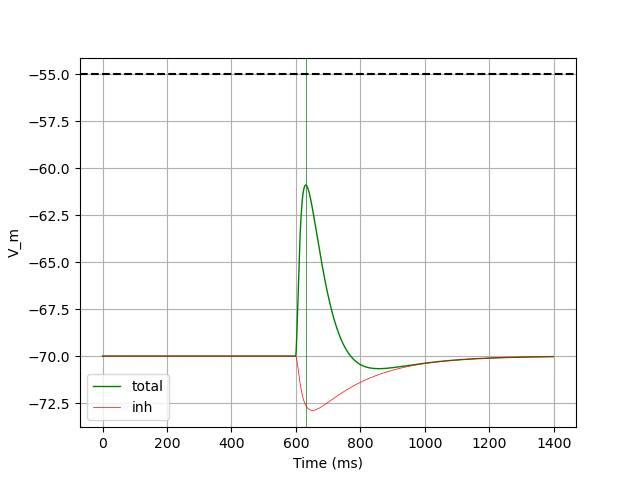

In [8]:
def show_mso_three_inputs(angle, deltat_inh, weight_inh, fig, ax):
    [l.remove() for l in ax.lines]

    p = paramsMSO3(
        angle,
        deltat_inh=deltat_inh,
        weight_inh=weight_inh,
    )
    res_total = mso(p)
    only_inh = mso(paramsMSO2(weight_exc=0, delta_t=deltat_inh))
    plot_voltage(ax, res_total, "g", "total")
    plot_voltage(ax, only_inh, "r", "inh", linewidth=0.5, plot_max=False)
    plot_threshold(ax)
    plot_axes_legend(ax)
    print("this is a right-side MSO cell")
    print(
        f"ipsi exc -> {p.delay_exc_i}ms,\tcntr exc -> {p.delay_exc_c}ms,\n\t\t\t     inh -> {p.delay_inh_c}ms"
    )


single_figure_setup(
    show_mso_three_inputs,
    angle=widgets.IntSlider(min=-90, max=90, step=15, value=0),
    deltat_inh=widgets.FloatSlider(min=-1.5, max=1, step=0.1),
    weight_inh=widgets.IntSlider(min=-15, max=0, step=1, value=-4),
)

# Four inputs

In [9]:
def paramsMSO4(
    angle: float = 0,
    deltat_inhi: float = 0,  # delay_exc_i - delay_inh_i
    deltat_inhc: float = 0,  # delay_exc_c - delay_inh_c
    **kwargs
):
    params = ParamsMSO4(**kwargs)
    itd = angle_to_itd(angle)
    delay_contralateral = 0
    params.delay_exc_c = params.delay_exc_i + itd + delay_contralateral
    params.delay_inh_i = params.delay_exc_i + deltat_inhi
    params.delay_inh_c = params.delay_exc_c + deltat_inhc
    return params

interactive(children=(IntSlider(value=0, description='angle', max=90, min=-90, step=15), FloatSlider(value=0.0…

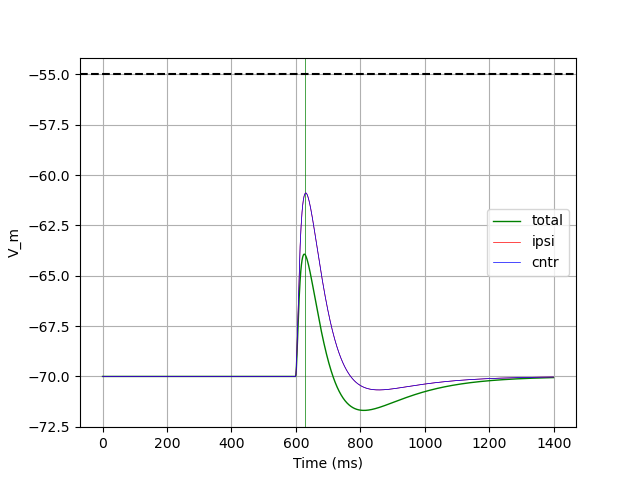

In [10]:
def show_mso_four_inputs(
    angle, deltat_inhi, deltat_inhc, weight_inh_i, weight_inh_c, fig, ax
):
    [l.remove() for l in ax.lines]
    p = paramsMSO4(
        angle,
        deltat_inhi,
        deltat_inhc,
        weight_inh_i=weight_inh_i,
        weight_inh_c=weight_inh_c,
    )
    res_total = mso(p)
    res_ipsi = mso(paramsMSO2(delta_t=deltat_inhi, weight_inh=weight_inh_i))
    res_contra = mso(
        paramsMSO2(
            delta_t=deltat_inhc,
            weight_inh=weight_inh_c,
            delay_exc_i=p.delay_exc_i + angle_to_itd(angle),
        )
    )
    max_total = time_max_voltage(res_total)
    # res_only_inh = mso(paramsMSO4())
    plot_voltage(ax, res_total, "g", "total")
    plot_voltage(ax, res_ipsi, "r", "ipsi", linewidth=0.5, plot_max=False)
    plot_voltage(ax, res_contra, "b", "cntr", linewidth=0.5, plot_max=False)
    plot_threshold(ax)
    plot_axes_legend(ax)
    print(
        f"ipsi exc -> {p.delay_exc_i}ms,\tcntr exc -> {p.delay_exc_c}ms,\nipsi inh -> {p.delay_inh_i}ms,\tcntr inh -> {p.delay_inh_c}ms"
    )
    print(f"peak time {max_total}, max V_m {max(res_total['V_m'])}")


single_figure_setup(
    show_mso_four_inputs,
    angle=widgets.IntSlider(min=-90, max=90, step=15, value=0),
    deltat_inhi=widgets.FloatSlider(min=-1.5, max=1, step=0.01),
    deltat_inhc=widgets.FloatSlider(min=-1.5, max=1, step=0.1),
    weight_inh_i=widgets.IntSlider(min=-15, max=0, step=1, value=-4),
    weight_inh_c=widgets.IntSlider(min=-15, max=0, step=1, value=-4),
)

interactive(children=(IntSlider(value=-6, description='weight_inh_i', max=0, min=-15), IntSlider(value=-1, des…

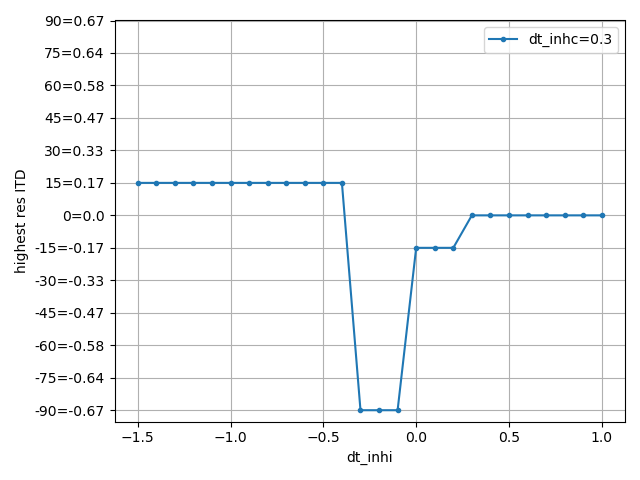

In [11]:
@memory.cache
def best_itd_curve(deltat_inhc, angles, weight_inh_i, weight_inh_c):
    deltat_inhis = [i / 10 for i in (range(-15, 11, 1))]
    max_for_deltat_inhi = []
    for deltat_inhi in deltat_inhis:
        res = {}
        for angle in angles:
            p = paramsMSO4(
                angle,
                deltat_inhi,
                deltat_inhc,
                weight_exc_i=2,
                weight_exc_c=2,
                weight_inh_i=weight_inh_i,
                weight_inh_c=weight_inh_c,
            )
            res_total = mso(p)
            res[angle] = np.max(res_total["V_m"])
        max_for_deltat_inhi.append(max(res, key=res.get))
    return deltat_inhis, max_for_deltat_inhi


def show_inhi_influence_on_best_itd(weight_inh_i, weight_inh_c, fig, ax):
    [l.remove() for l in ax.lines]

    angles = list(range(-90, 91, 15))
    deltat_inhcs = [i / 10 for i in (range(-15, 11, 1))]
    deltat_inhcs = [0.3]
    for deltat_inhc in deltat_inhcs:
        deltat_inhis, max_for_deltat_inhi = best_itd_curve(
            deltat_inhc, angles, weight_inh_i, weight_inh_c
        )
        ax.plot(
            deltat_inhis,
            max_for_deltat_inhi,
            marker=".",
            label=f"dt_inhc={deltat_inhc}",
        )

    ax.set_yticks(angles, labels=[f"{i}={angle_to_itd(i)}" for i in angles])
    ax.set_xlabel("dt_inhi")
    ax.set_ylabel("highest res ITD")
    plt.tight_layout()
    ax.legend()


single_figure_setup(
    show_inhi_influence_on_best_itd,
    weight_inh_i=widgets.IntSlider(min=-15, max=0, step=1, value=-6),
    weight_inh_c=widgets.IntSlider(min=-15, max=0, step=1, value=-1),
)

In [14]:
out_result_dt = widgets.Output()
result_container_dt = widgets.Box(
    [out_result_dt],
    layout=widgets.Layout(
        min_width="fit-content",
        display="flex",
        flex_flow="column",
        flex="1 0 0",
        max_width="500px",
        border="2px solid orange",
    ),
)
out_extra_dt = widgets.Output()
extra_container_dt = widgets.Box(
    [out_extra_dt],
    layout=widgets.Layout(
        min_width="fit-content",
        overflow="auto",
        display="flex",
        border="1px solid blue",
        width="600px",
        flex="1 0 1",
    ),  # height="900px",
)
outer_hbox_dt = widgets.HBox(
    [result_container_dt, extra_container_dt], layout=widgets.Layout(width="100%")
)


def best_itd_per_inhi(deltat_inhc, deltat_inhis, angles, weight_inh_i, weight_inh_c):
    max_vm_angles = []
    debug_complete_vms = []
    max_vms = []
    for deltat_inhi in deltat_inhis:
        res = {}
        debug_total_res = {}
        for angle in angles:
            p = paramsMSO4(
                angle,
                deltat_inhi,
                deltat_inhc,
                weight_exc_i=2,
                weight_exc_c=2,
                weight_inh_i=weight_inh_i,
                weight_inh_c=weight_inh_c,
            )
            res_total = mso(p)
            res[angle] = max(res_total["V_m"])
            debug_total_res[angle] = res_total
        angle_with_max_vm = max(res, key=res.get)
        max_vm_angles.append(angle_with_max_vm)
        max_vms.append(res[angle_with_max_vm])
        debug_complete_vms.append(debug_total_res)
    return max_vm_angles, max_vms, debug_complete_vms


@out_result_dt.capture(clear_output=True, wait=True)
def show_dt_impact_on_best_itd(weight_inh_i, weight_inh_c):
    with plt.ioff():
        fig, ax = plt.subplots(1, 1)

    angles = list(range(-90, 91, 15))
    deltat_inhis = [i / 100 for i in (range(-70, 50, 10))]
    deltat_inhcs = [i / 100 for i in (range(-20, -8, 1))]
    # deltat_inhcs = [i / 10 for i in (range(-14, 10, 1))]
    # deltat_inhis = [i / 10 for i in (range(-14, 10, 1))]
    max_angle = []
    max_vm = []
    debug_complete_vm = []
    # [inhc_row: [result_per_inhi,]]
    # deltat_inhcs = [0.3]
    for deltat_inhc in deltat_inhcs:
        print(f"now checking dt_inhc={deltat_inhc}")
        max_for_deltat_inhi, max_vms, debug_complete_vms = best_itd_per_inhi(
            deltat_inhc, deltat_inhis, angles, weight_inh_i, weight_inh_c
        )
        max_angle.append(max_for_deltat_inhi)
        max_vm.append(max_vms)
        debug_complete_vm.append(debug_complete_vms)

    im, cbar = heatmap(
        np.array(max_angle),
        [str(i) for i in deltat_inhis],
        [str(i) for i in deltat_inhcs],
        ax=ax,
        cmap="YlGn",
        cbarlabel="angle",
    )
    with plt.ioff():
        fig_detail, ax_detail = plt.subplots()

    texts = annotate_heatmap(im, valfmt="{x:.0f}")
    highlight_selected = plt.Circle(
        (0, 0), 0.7, zorder=10, facecolor="none", edgecolor="red", linewidth=2
    )
    highlight_selected.set_visible(False)
    ax.add_patch(highlight_selected)

    @out_extra_dt.capture(wait=True)
    def onclick(event):
        if event.mouseevent.button != 1:
            return  # not a click
        [l.remove() for l in ax_detail.lines]
        x, y = event.artist.get_position()
        highlight_selected.set_center((x, y))
        highlight_selected.set_visible(True)
        fig.canvas.draw()
        print(f"additional info for position {x+1},{y+1}")
        print(
            f"plot for dt_inhi={deltat_inhis[x]}, dt_inhcs={deltat_inhcs[y]} (w_inhi={weight_inh_i},w_inhc={weight_inh_c})"
        )
        angle_to_vm = debug_complete_vm[y][x]
        m_a = max_angle[y][x]
        angle_to_max_vm = {a: max(m["V_m"]) for a, m in angle_to_vm.items()}
        max_angle_now = max(angle_to_max_vm, key=angle_to_max_vm.get)
        print(f"max found pre: {max_angle[y][x]} with v_m {max_vm[y][x]}")
        print(
            f"max found now: {max_angle_now} with v_m {angle_to_max_vm[max_angle_now]}"
        )
        plot_voltage(
            ax_detail, angle_to_vm[m_a], label=f"{m_a}", color="r", linewidth=1.5
        )
        for angle, result in {k: v for k, v in angle_to_vm.items() if k != m_a}.items():
            plot_voltage(
                ax_detail, result, label=f"{angle}", linewidth=0.2, plot_max=False
            )
        fig_detail.legend()
        fig_detail.show()

    cid = fig.canvas.mpl_connect("pick_event", onclick)

    ax.set_ylabel("dt_inhi")
    ax.set_xlabel("dt_inhc")
    ax.set_title("effect of different dt_inh (in max angle response)")
    ax.grid(False)
    # plt.tight_layout()
    fig.show()


WEIGHT_INH_I = -8
WEIGHT_INH_C = -2

show_dt_impact_on_best_itd(WEIGHT_INH_I, WEIGHT_INH_C)
display(outer_hbox_dt)

In [12]:
angle_to_itd(90) - angle_to_itd(85)

0.010000000000000009

In [18]:
def double_figure_setup(draw_fun, **kwargs):
    name = draw_fun.__name__
    detail_name = f"{name}_detail"
    if name in figures:
        plt.close(figures.pop(name)[0])
        plt.close(figures.pop(detail_name)[0])

    with plt.ioff():
        fig, ax = plt.subplots(1, 1)
        fig_det, ax_det = plt.subplots(1, 1)
        figures[name] = [fig, ax]
        figures[detail_name] = [fig_det, ax_det]

    out_result = widgets.Output()
    result_container = widgets.Box(
        [out_result],
        layout=widgets.Layout(
            min_width="fit-content",
            display="flex",
            flex_flow="column",
            flex="1 0 0",
            max_width="500px",
            border="2px solid orange",
        ),
    )
    out_extra = widgets.Output()
    extra_container = widgets.Box(
        [out_extra],
        layout=widgets.Layout(
            min_width="fit-content",
            overflow="auto",
            display="flex",
            border="1px solid blue",
            width="600px",
            flex="1 0 1",
        ),  # height="900px",
    )
    outer_hbox = widgets.HBox(
        [result_container, extra_container], layout=widgets.Layout(width="100%")
    )
# (clear_output=True,wait=True)
    with out_result:
        draw_fun(**kwargs, out_extra=out_extra, fig=fig, ax=ax, fig_detail=fig_det, ax_detail=ax_det)

    display(outer_hbox)
    

In [29]:
def best_itd_per_w_inhi(deltat_inhi, deltat_inhc, angles, weight_inhis, weight_inhc):
    max_vm_angles = []
    max_vms = []
    debug_complete_vms = []
    for weight_inhi in weight_inhis:
        res = {}
        debug_total_res = {}
        for angle in angles:
            p = paramsMSO4(
                angle,
                deltat_inhi,
                deltat_inhc,
                weight_exc_i=2,
                weight_exc_c=2,
                weight_inh_i=weight_inhi,
                weight_inh_c=weight_inhc,
            )
            res_total = mso(p)
            res[angle] = max(res_total["V_m"])
            debug_total_res[angle] = res_total
        angle_with_max_vm = max(res, key=res.get)
        max_vm_angles.append(angle_with_max_vm)
        max_vms.append(res[angle_with_max_vm])
        debug_complete_vms.append(debug_total_res)
    return max_vm_angles, max_vms, debug_complete_vms


def single_conf_all_angles(angles, dt_inhi, dt_inhc, w_inhi, w_inhc):
    res = {}
    for angle in angles:
        res[angle] = mso(
            paramsMSO4(
                angle,
                dt_inhi,
                dt_inhc,
                weight_exc_i=2,
                weight_exc_c=2,
                weight_inh_i=w_inhi,
                weight_inh_c=w_inhc,
            )
        )
    return res


def show_winh_impact_on_best_itd(
    dt_inhi, dt_inhc, out_extra, fig, ax, fig_detail, ax_detail
):
    angles = list(range(-90, 91, 5))
    w_inhis = [i / 10 for i in range(-200, -101, 10)]
    w_inhcs = [i / 10 for i in range(-120, -21, 10)]
    # w_inhcs = [i/10 for i in range(-110, -91, 2)]
    # w_inhis = [i/10 for i in range(-70, -51, 2)]
    max_angle = []
    max_vm = []
    debug_complete_vm = []
    # [inhc_row: [result_per_inhi,]]
    for w_inhc in w_inhcs:
        print(f"now checking w_inhc={w_inhc}")
        max_angles, max_vms, debug_complete_vms = best_itd_per_w_inhi(
            dt_inhi, dt_inhc, angles, w_inhis, w_inhc
        )
        max_vm.append(max_vms)
        max_angle.append(max_angles)
        debug_complete_vm.append(debug_complete_vms)

    im, cbar = heatmap(
        np.array(max_angle),
        [str(i) for i in w_inhcs],
        [str(i) for i in w_inhis],
        ax=ax,
        cmap="YlGn",
        cbarlabel="angle",
    )

    @out_extra.capture(wait=True)
    def onclick(event):
        [l.remove() for l in ax_detail.lines]
        x, y = event.artist.get_position()
        print(f"additional info for position {x+1},{y+1}")
        print(
            f"plot for w_inhi={w_inhis[x]}, w_inhc={w_inhcs[y]} (dt_inhi={dt_inhi},dtinhc={dt_inhc})"
        )
        angle_to_vm = debug_complete_vm[y][x]
        m_a = max_angle[y][x]
        angle_to_max_vm = {a: max(m["V_m"]) for a, m in angle_to_vm.items()}
        max_angle_now = max(angle_to_max_vm, key=angle_to_max_vm.get)
        print(f"max found pre: {max_angle[y][x]} with v_m {max_vm[y][x]}")
        print(
            f"max found now: {max_angle_now} with v_m {angle_to_max_vm[max_angle_now]}"
        )
        plot_voltage(
            ax_detail, angle_to_vm[m_a], label=f"{m_a}", color="r", linewidth=1.5
        )
        for angle, result in {k: v for k, v in angle_to_vm.items() if k != m_a}.items():
            plot_voltage(
                ax_detail, result, label=f"{angle}", linewidth=0.2, plot_max=False
            )
        fig_detail.legend()
        fig_detail.show()

    cid = fig.canvas.mpl_connect("pick_event", onclick)
    texts = annotate_heatmap(im, valfmt="{x:.0f}")
    ax.set_xlabel("w_inhi")
    ax.set_ylabel("w_inhc")
    ax.set_title(f"effect of different w_inh (dt: {dt_inhi}i,{dt_inhc}c)")
    ax.grid(False)
    plt.tight_layout()
    fig.show()


DT_INHI = 0.1
DT_INHC = -0.4

double_figure_setup(show_winh_impact_on_best_itd, dt_inhi=DT_INHI, dt_inhc=DT_INHC)


/tmp/ipykernel_75763/2596541228.py:9: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.


In [38]:
def single_figure_setup_no_interact(draw_fun, **kwargs):
    name = draw_fun.__name__
    if name in figures:
        plt.close(figures.pop(name)[0])

    with plt.ioff():
        fig, ax = plt.subplots(1, 1)
        figures[name] = [fig, ax]

    draw_fun(**kwargs,fig=fig,ax=ax)

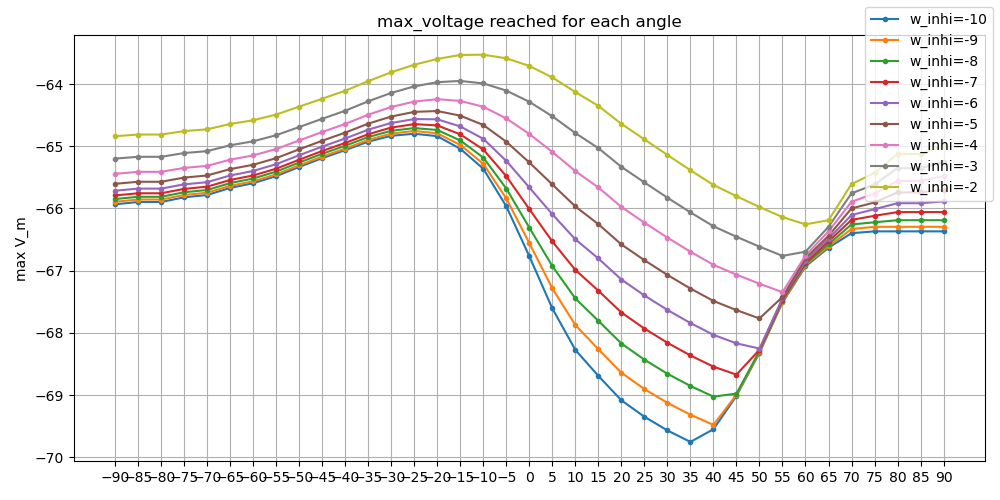

In [48]:
# %%script false --no-raise-error # correction
ANGLES = list(range(-90, 91, 5))


def show_max_vm_per_angle(w_inhi, w_inhc, dt_inhi, dt_inhc, angles, fig, ax):
    for w_inhi in w_inhi:
        m = []
        for angle in angles:
            res = mso(
                paramsMSO4(
                    angle,
                    dt_inhi,
                    dt_inhc,
                    weight_inh_i=w_inhi,
                    weight_inh_c=w_inhc,
                )
            )
            m.append(max(res["V_m"]))
        ax.plot(angles, m, ".-", label=f'w_inhi={w_inhi}')
    ax.set_title(f"max_voltage reached for each angle")
    ax.set_ylabel("max V_m")
    fig.set_figwidth(10)
    fig.set_figheight(5)
    plt.setp([ax], xticks=angles)
    ax.grid(True)
    plt.tight_layout()
    fig.legend()
    fig.show()


DT_INHI = 0.1
DT_INHC = -0.5
W_INHI = list(range(-10,-1))
W_INHC = -6

single_figure_setup_no_interact(
    show_max_vm_per_angle,
    w_inhi=W_INHI,
    w_inhc=W_INHC,
    dt_inhi=DT_INHI,
    dt_inhc=DT_INHC,
    angles=ANGLES,
)